In [2]:
%run preprocess.ipynb

Using TensorFlow backend.


# Ensemble

In [3]:
trn, val = get_features('flat_feats')

In [4]:
tst = get_test_data()

del trn, val

In [5]:
print(trn[0].shape, trn[1].shape, tst[0].shape, tst[1].shape)

(31447, 2048) (31447, 24) (14952, 2048) (14952, 24)


In [6]:
total_trn = bcolz.carray(np.empty((0,2048), 'float32'))

In [7]:
total_trn.append(trn[0])
total_trn.append(tst[0])

In [9]:
total_trn.shape

(46399, 2048)

In [10]:
total_y_trn = np.concatenate([trn[1], tst[1]])

In [38]:
np.concatenate([trn[1], tst[1]]).shape

(46399, 24)

In [35]:
ip = Input(trn[0].shape[1:])
expand = Reshape((1,24))

fc_list = [ Dense(24, activation='softmax')(ip) for i in range(6)]
fc_list = [ expand(i) for i in fc_list ]
x = Concatenate(axis=1)(fc_list)
x = AveragePooling1D(6)(x)
x = Reshape((24,))(x)
m = Model(ip, x)
#, kernel_regularizer=regularizers.l2(0.001)

In [36]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 24)           49176       input_16[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 24)           49176       input_16[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 24)           49176       input_16[0][0]                   
__________________________________________________________________________________________________
dense_44 (

In [35]:
m.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [37]:
bc_it_trn = BcolzArrayIterator(total_trn[0], total_y_trn, batch_size=64)
bc_it_val = BcolzArrayIterator(val[0], val[1], batch_size=64)

In [64]:
ckpt = ModelCheckpoint('models/6fc_resnet_wt.h5', save_best_only=True, monitor='val_acc')

In [ ]:
m.predict_generator()

In [65]:
hist = m.fit_generator(bc_it_trn, steps_per_epoch=491, validation_data=bc_it_val, validation_steps=120,
                              epochs=100, callbacks=[ckpt])

Epoch 1/100
491/491 [==============================] - 6s 13ms/step - loss: 0.5217 - acc: 0.7677 - val_loss: 2.1205 - val_acc: 0.5962
Epoch 2/100
491/491 [==============================] - 6s 13ms/step - loss: 0.5180 - acc: 0.7691 - val_loss: 2.1336 - val_acc: 0.5962
Epoch 3/100
491/491 [==============================] - 6s 11ms/step - loss: 0.5175 - acc: 0.7689 - val_loss: 2.1490 - val_acc: 0.5958
Epoch 4/100
491/491 [==============================] - 6s 13ms/step - loss: 0.5164 - acc: 0.7691 - val_loss: 2.1683 - val_acc: 0.5941
Epoch 5/100
491/491 [==============================] - 6s 13ms/step - loss: 0.5160 - acc: 0.7695 - val_loss: 2.1802 - val_acc: 0.5948
Epoch 6/100
491/491 [==============================] - 7s 14ms/step - loss: 0.5152 - acc: 0.7695 - val_loss: 2.1801 - val_acc: 0.5940
Epoch 7/100
491/491 [==============================] - 7s 13ms/step - loss: 0.5144 - acc: 0.7698 - val_loss: 2.2182 - val_acc: 0.5944
Epoch 8/100
491/491 [==============================] - 8s 15ms

KeyboardInterrupt: 

Text(0.5,1,'Resnet50 without finetuning on full dataset')

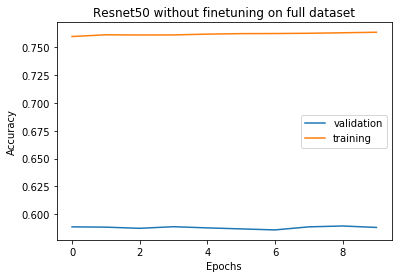

In [66]:
fig = plt.figure()
plt.plot(hist.history['val_acc'], label='validation')
plt.plot(hist.history['acc'], label='training')
plt.legend()
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Resnet50 without finetuning on full dataset')
# fig.savefig('resnet_wo_finetune_training_acc_3.png')

In [2]:
m = load_model('models/6fc_resnet_wt.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


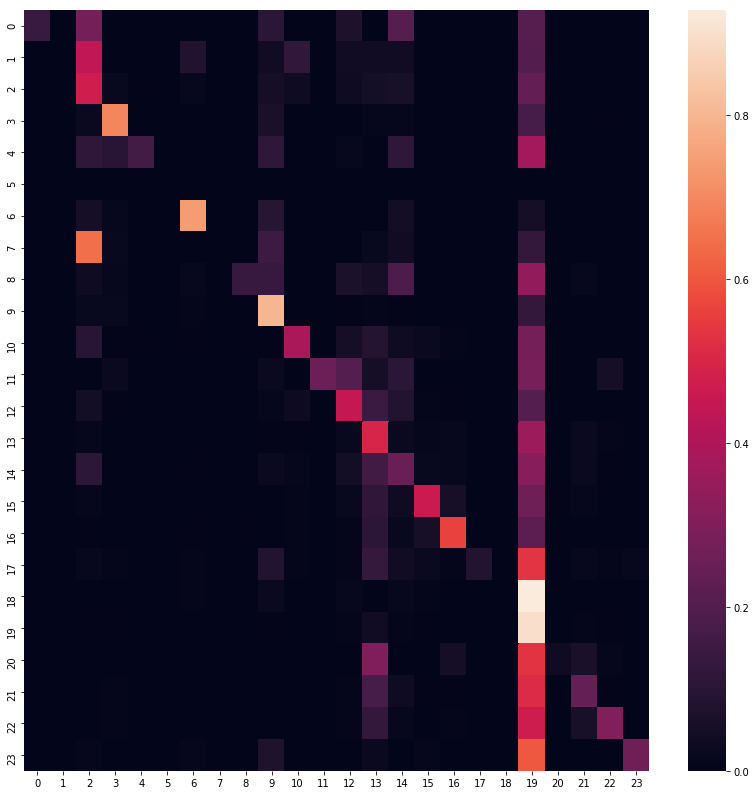

In [46]:
cm_n = get_confusion_matrix(m, val[0], val[1], 'c3')

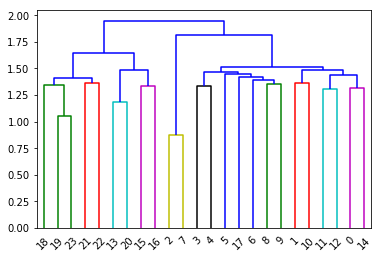

In [47]:
dd = get_dendrogram(cm_n)

In [54]:
clusters=[[18,19,23], [21,22], [13,20], [15,16], [2,7], [3,4], [5,17,6], [8,9], [1,10], [11,12], [0,14]]

[18, 19, 23]
[21, 22]
[13, 20]
[15, 16]
[2, 7]
[3, 4]
[5, 17, 6]
[8, 9]
[1, 10]
[11, 12]
[0, 14]


OSError: [Errno 36] File name too long: 'images/c3_Varsity_Typography_Sports and Team Jersey_People and Places_Biker_Graphic_Music_Humour and Comic_Superhero_Geometric_Checked_Solid_Self Design_Horizontal Stripes_Sports_Striped_Tie and Dye_Colourblocked_Polka Dots_Conversational_Camouflage_Floral_Tribal_Abstract.png'

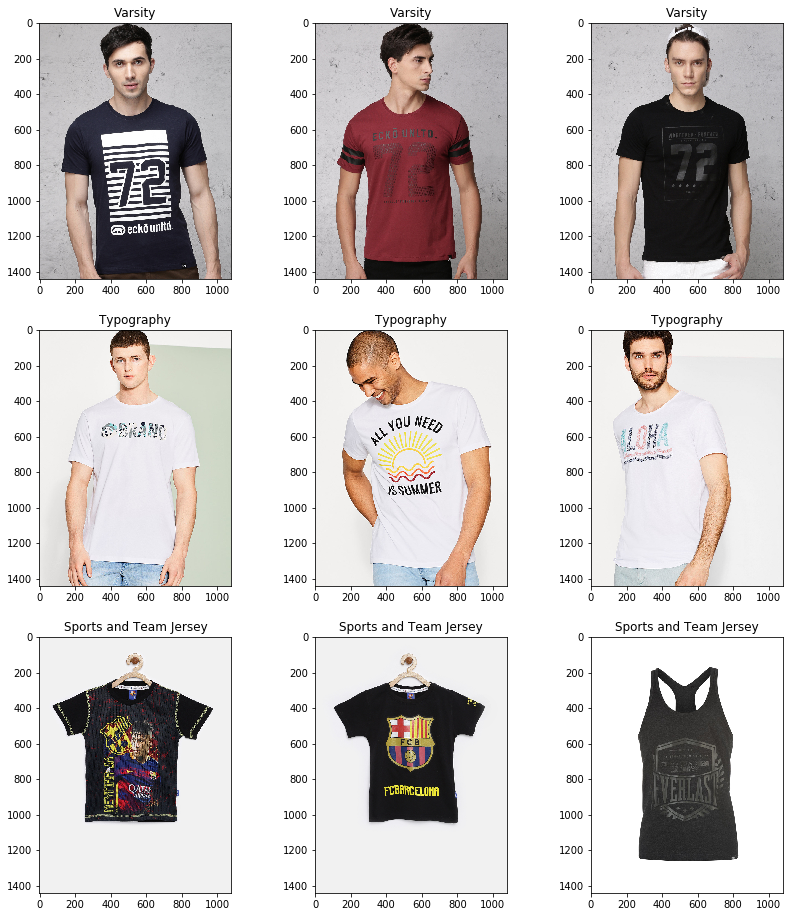

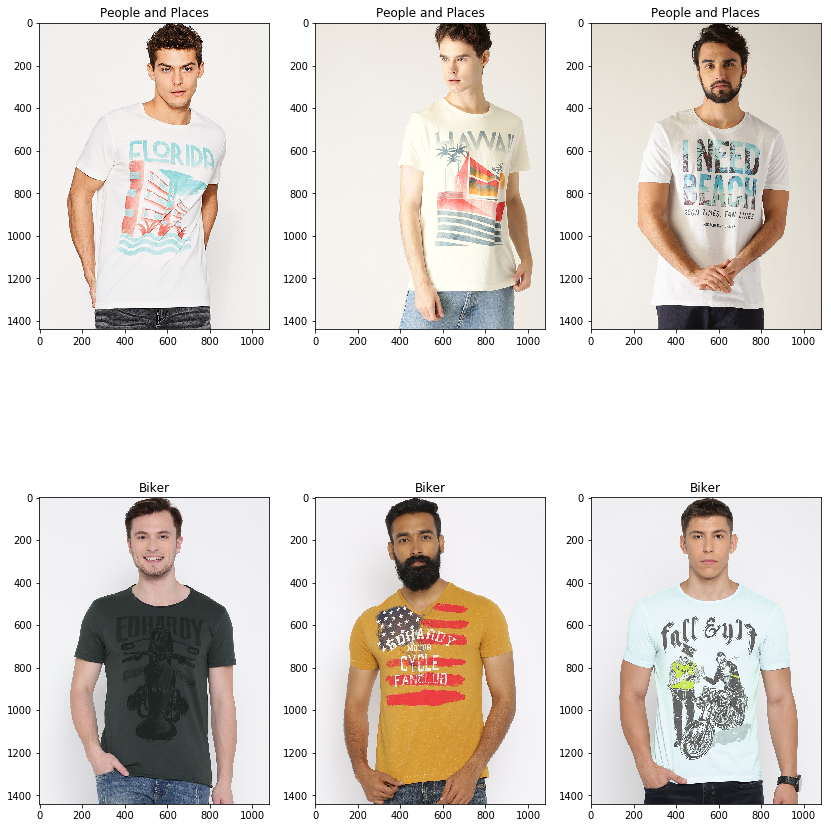

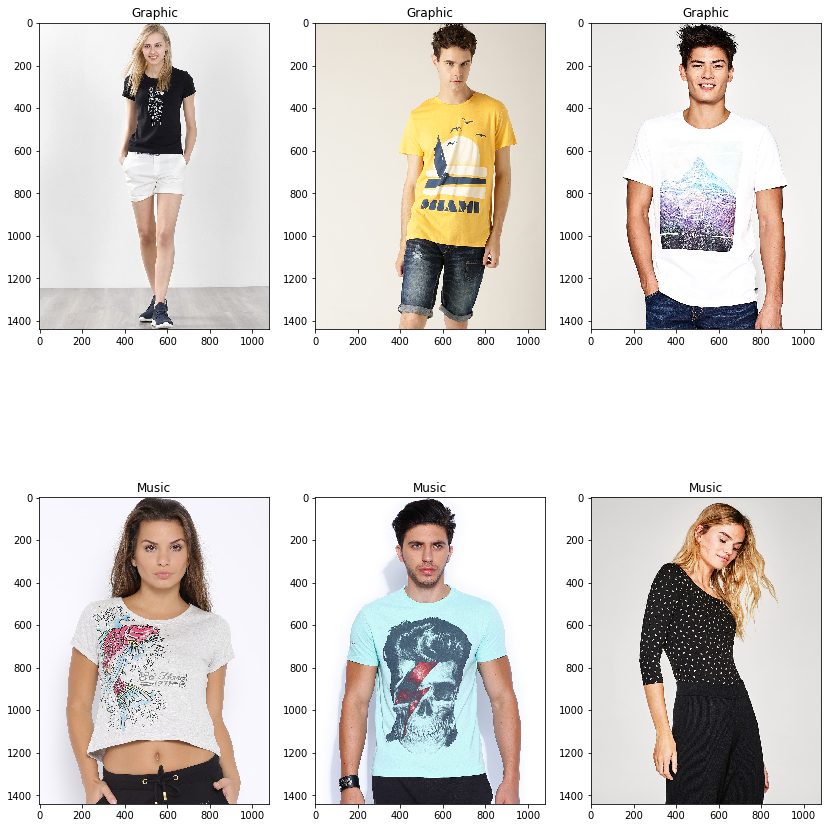

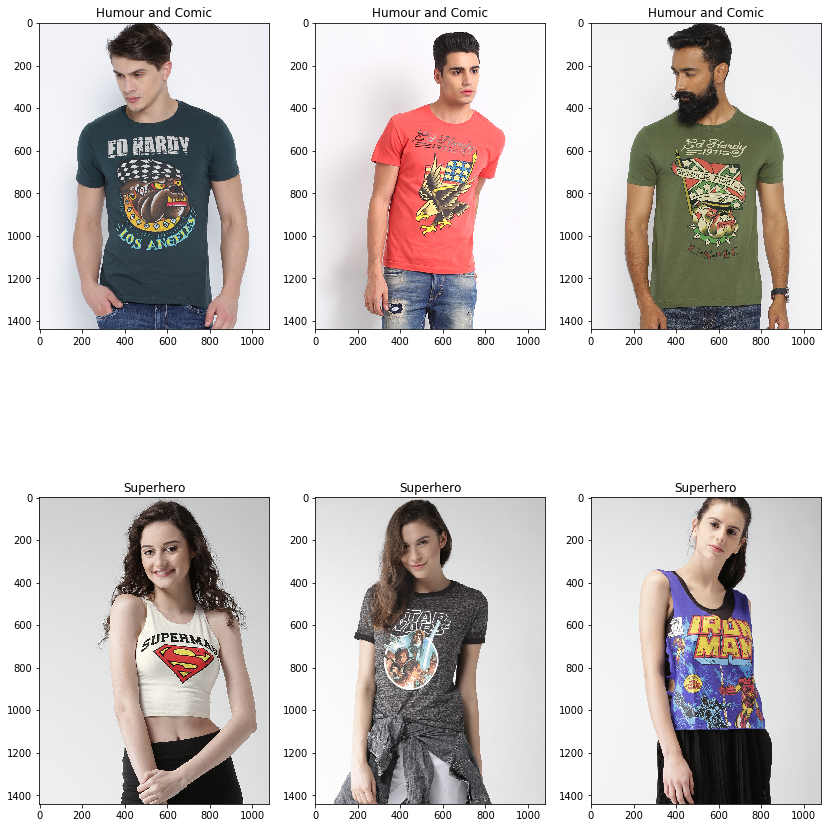

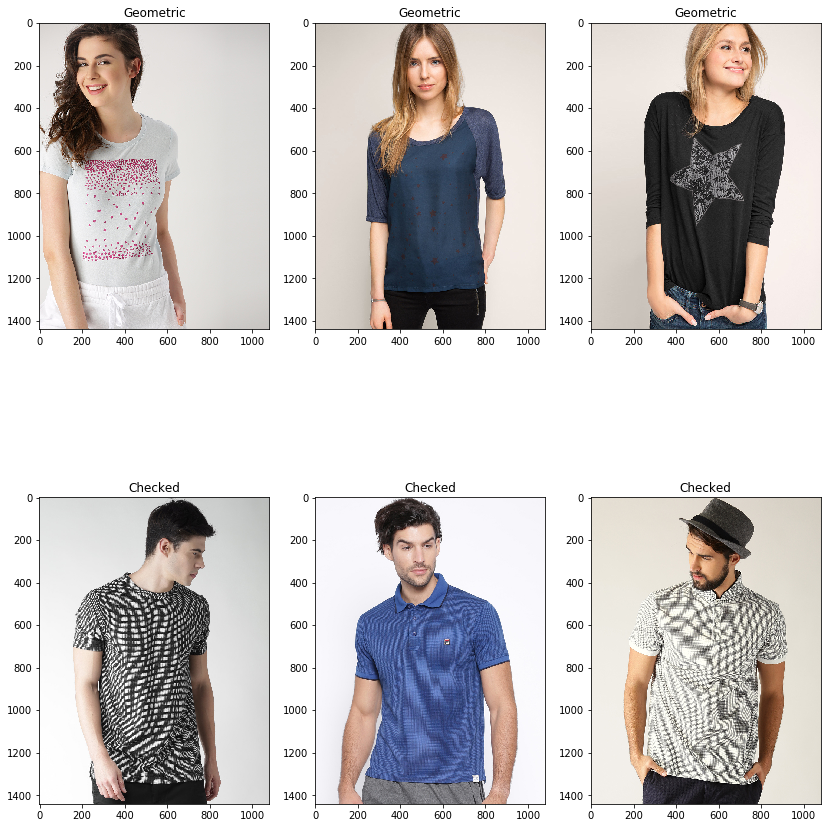

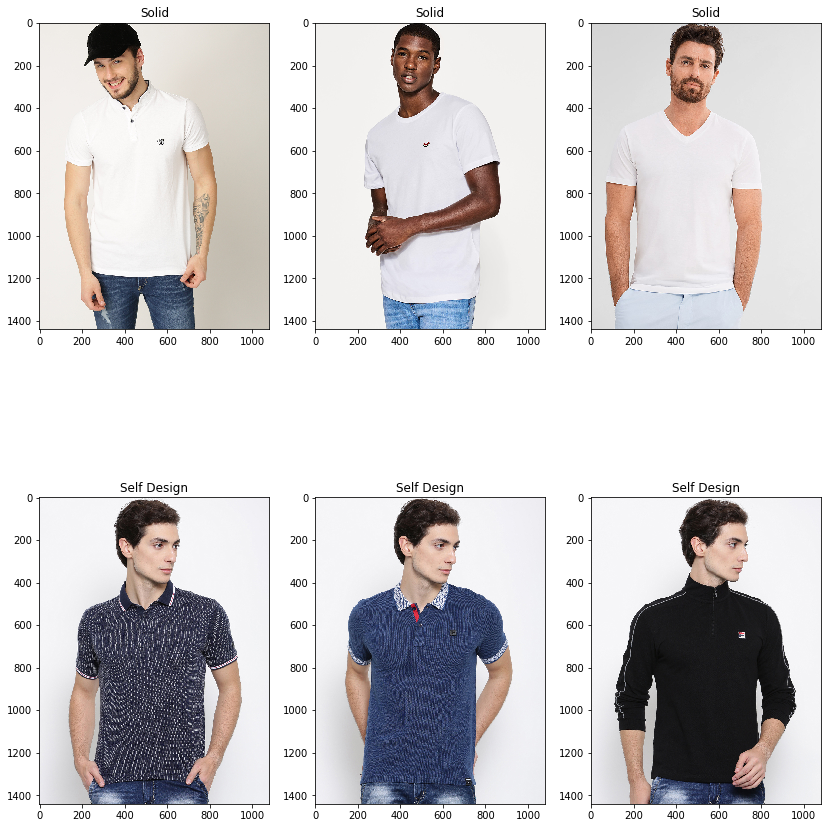

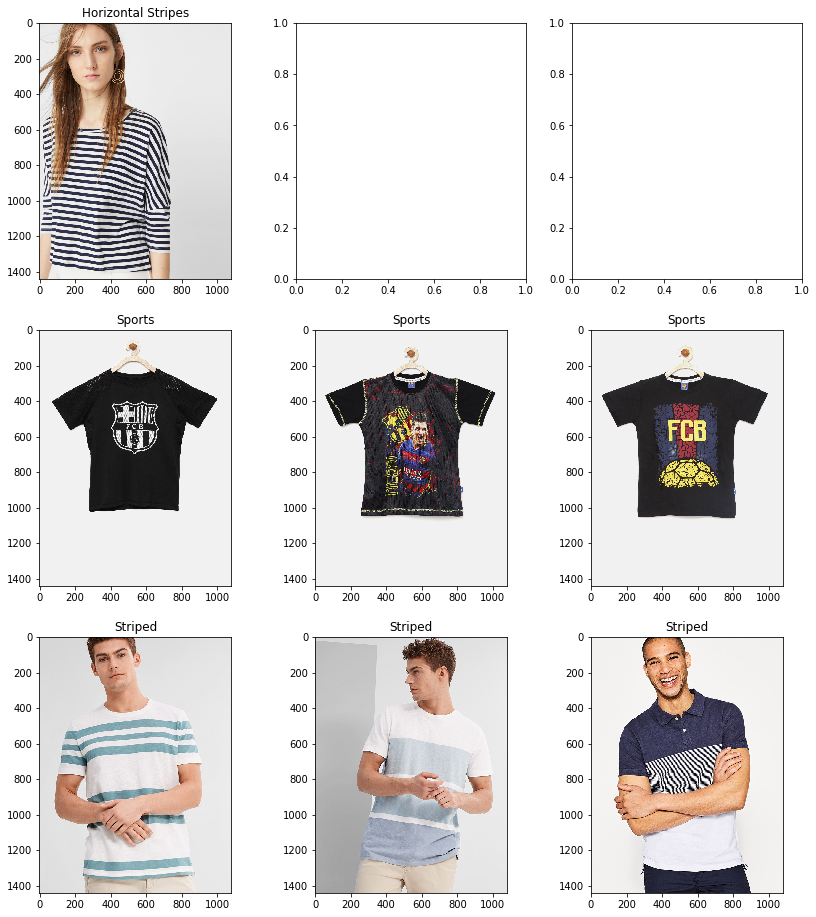

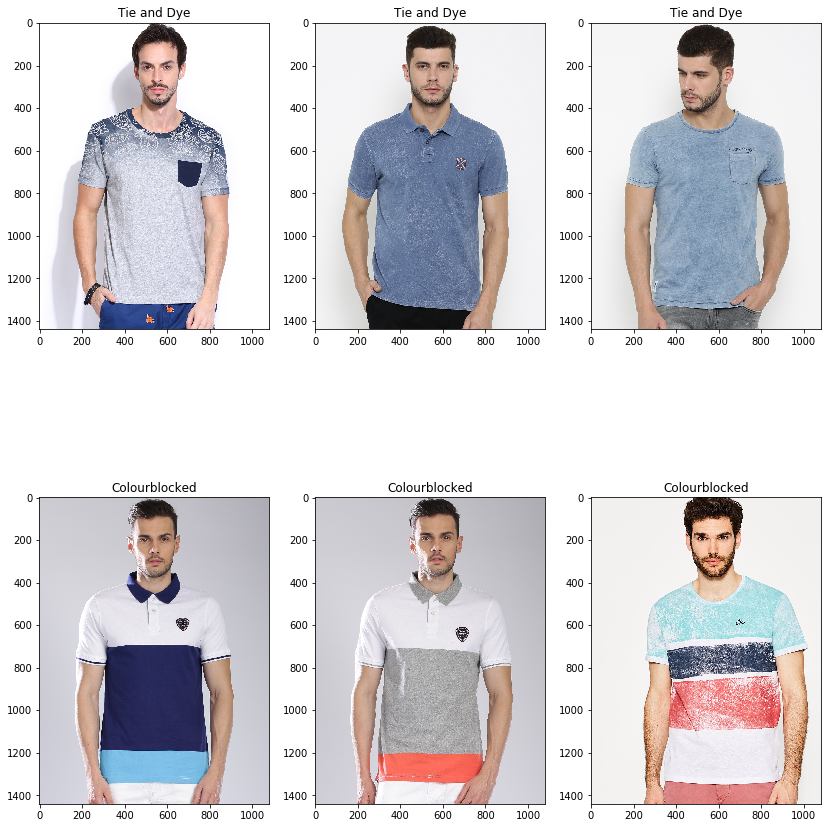

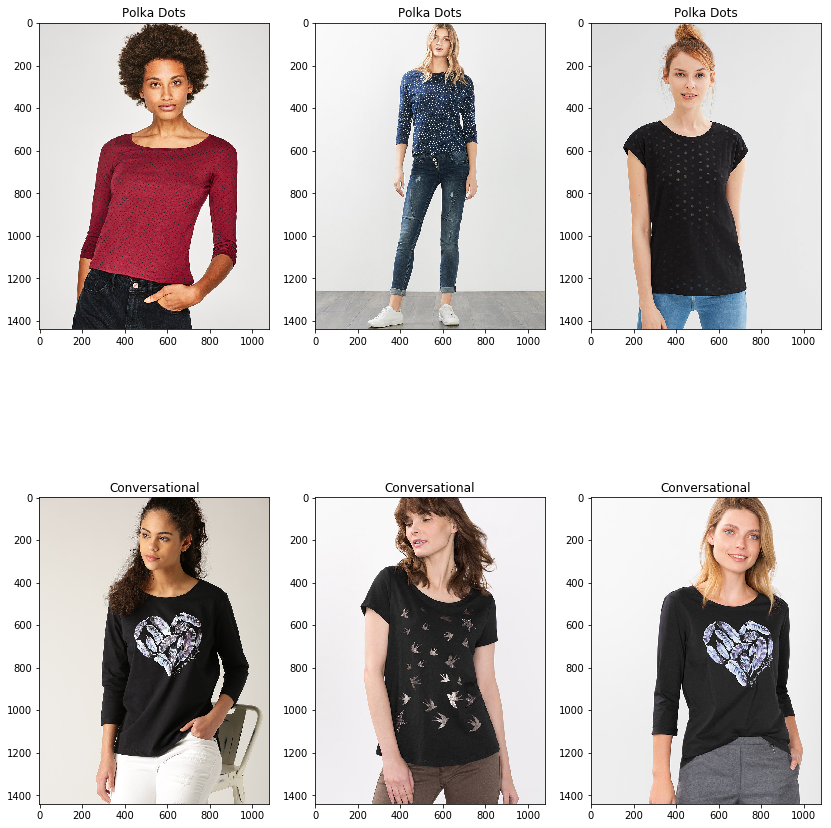

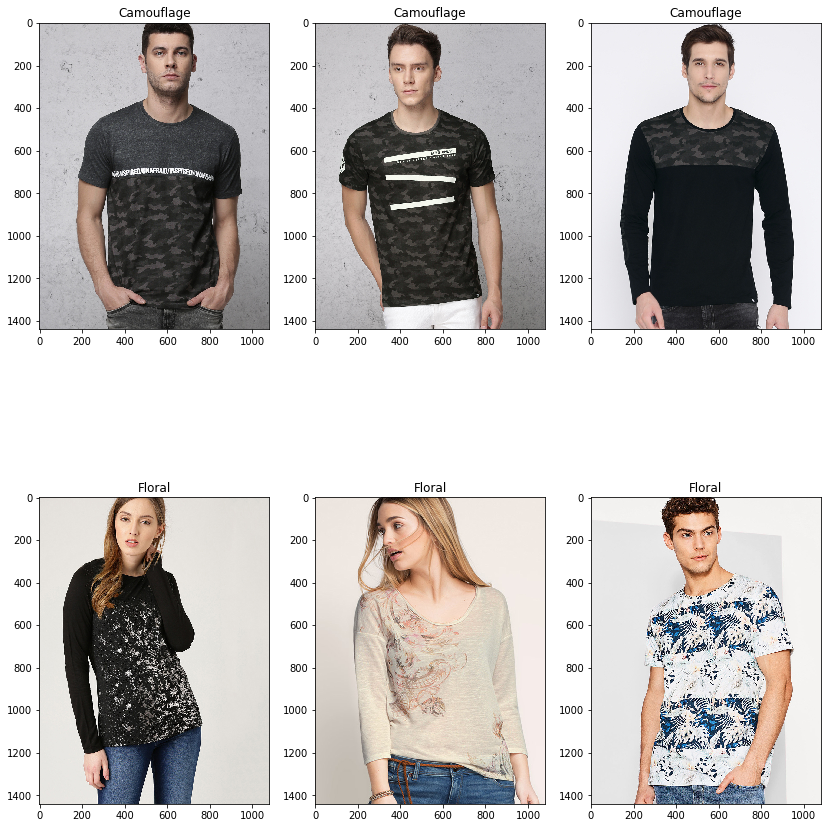

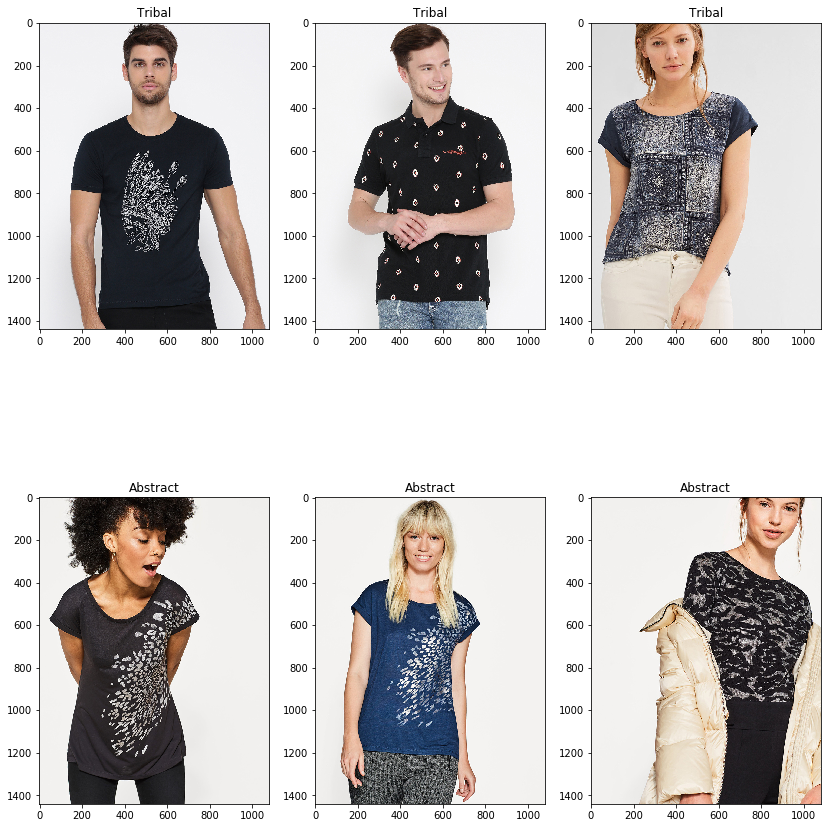

In [55]:
get_cluster_images(clusters, 'c3')

In [ ]:
get_submission_file()

labels = get_submission_file(m)

labels[:5]

# pooling

In [3]:
trn, val, base_model = get_features('mid_feats')

In [4]:
print(trn[0].shape, trn[1].shape)

(31447, 28, 28, 512) (31447, 24)


In [18]:
ip = Input(trn[0].shape[1:])
x = Lambda(bilinearpool)(ip)
x = Lambda(lambda x: K.expand_dims(x))(x)
a = Conv2D(1, (1,512))(x)
a = Flatten()(a)
b = Conv2D(1, (512,1))(x)
b = Flatten()(b)
x = Concatenate()([a,b])
x = Dense(24, activation='softmax')(x)
m = Model(ip, x)
#, kernel_regularizer=regularizers.l2(0.001)
m.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [19]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 512)  0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 512, 512)     0           input_8[0][0]                    
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 512, 512, 1)  0           lambda_11[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 512, 1, 1)    513         lambda_12[0][0]                  
__________________________________________________________________________________________________
conv2d_10 

In [20]:
bc_it_trn = BcolzArrayIterator(trn[0], trn[1], batch_size=64)
bc_it_val = BcolzArrayIterator(val[0], val[1], batch_size=64)

In [21]:
hist = m.fit_generator(bc_it_trn, steps_per_epoch=491, validation_data=bc_it_val, validation_steps=120,
                              epochs=1)#, callbacks=[early_stops])

Epoch 1/1
313/491 [==================>...........] - ETA: 1:49 - loss: 2.4030 - acc: 0.3303

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['val_acc'], label='validation')
plt.plot(hist.history['acc'], label='training')
plt.legend()
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Resnet50 without finetuning on full dataset')
fig.savefig('resnet_wo_finetune_training_acc_2.png')